In [1]:
#loading basic dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading the data
data = pd.read_csv('Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')

#shape of the data
data.shape

(144, 1)

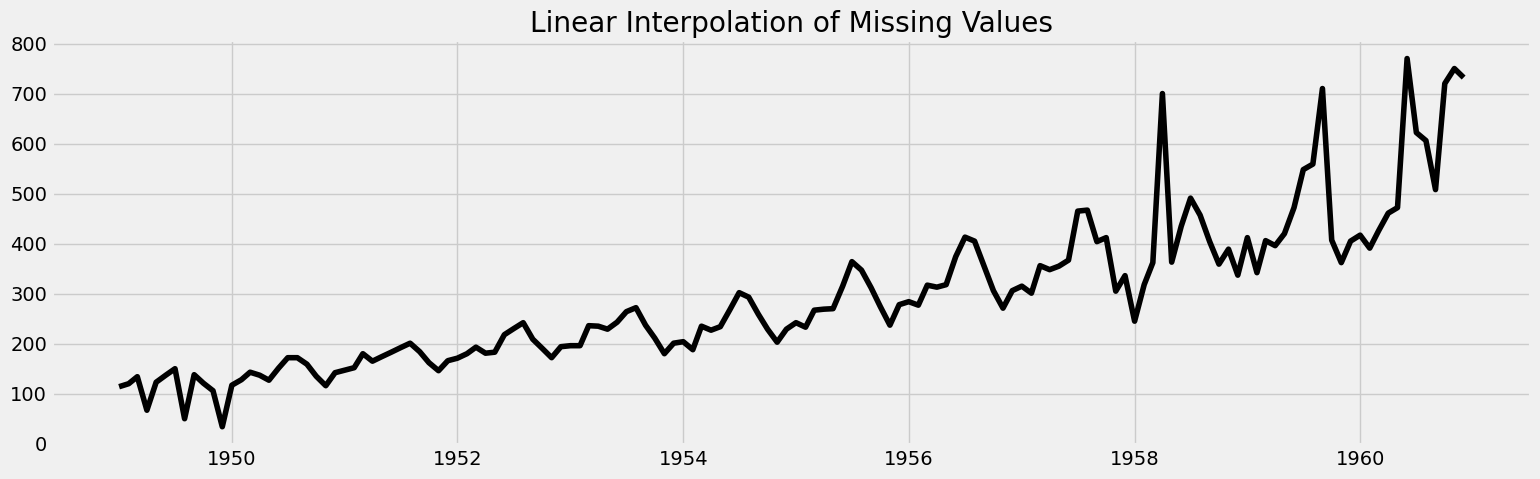

In [3]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear']=data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Customers_linear'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: 2.9806738090828993
n_lags: 1.0
p-value: 1.0
Critial Values:
   1%, -3.482087964046026
Critial Values:
   5%, -2.8842185101614626
Critial Values:
   10%, -2.578864381347275


In [5]:
#loading kpss from statsmodel
from statsmodels.tsa.stattools import kpss

result = kpss(data['Customers_linear'])
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'num lags: {result[2]}')
print('Critial Values:')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  


KPSS Statistic: 1.627985585760761
p-value: 0.01
num lags: 8
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\girij\AppData\Local\Temp\ipykernel_7196\340047527.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data['Customers_linear'])


# Non-Stationary Series to Stationary Series
There are two tools for converting a non-stationary series into a stationary series.

1)	Differencing

2)	Transformation

Differencing tool is used to make the mean constant for a time series. That means it removes the trend from the series. 

Differencing means to calculate the difference between consecutive observations. Differencing stabilises the mean of the time series by removing the trend from the series.


The mathematical formula for box cox transformation is:
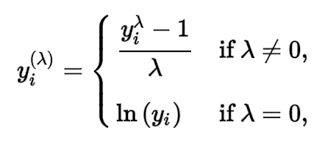

The procedure is to find the optimal value of lambda between -5 and +5 to minimize the variance of the time series.

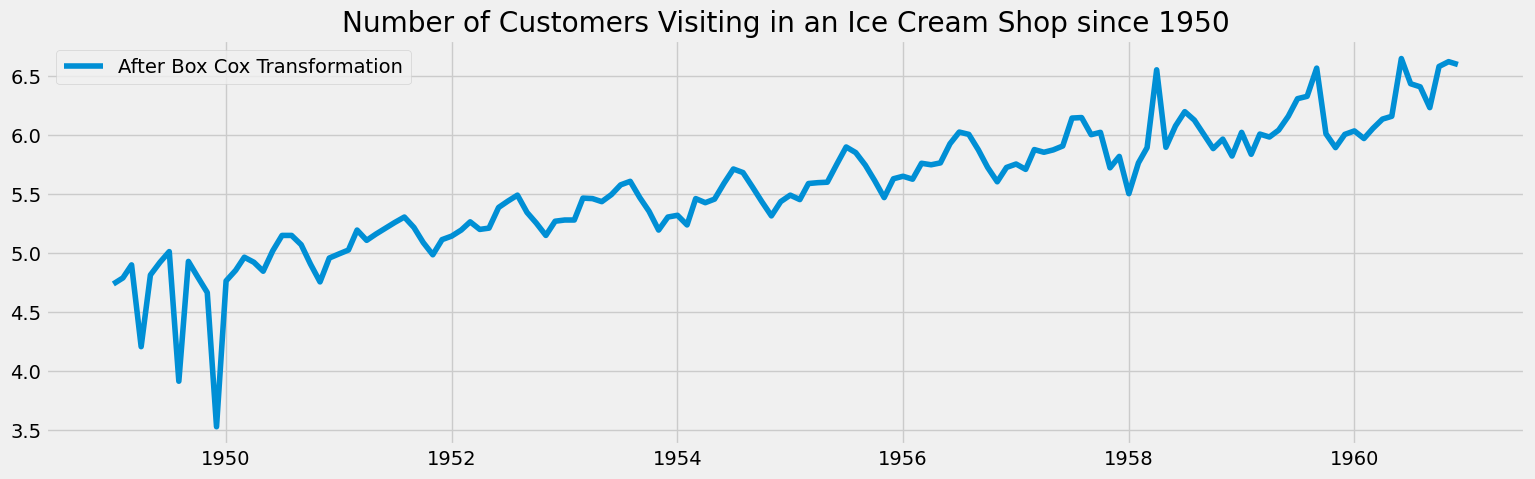

In [6]:
# box cox transformation
from scipy.stats import boxcox

data_boxcox = pd.Series(boxcox(data['Customers_linear'],lmbda=0),index=data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend()
plt.title("Number of Customers Visiting in an Ice Cream Shop since 1950")
plt.show()

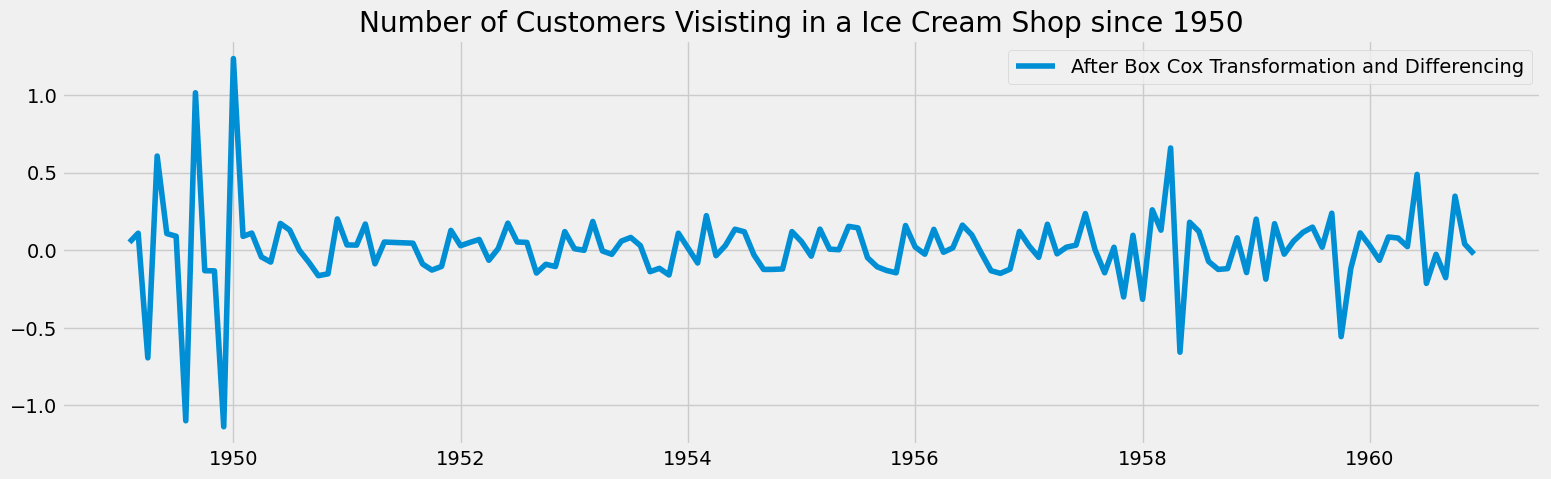

In [7]:
# differencing
data_boxcox_difference= pd.Series(data_boxcox - data_boxcox.shift(), index=data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

In [8]:
# checking stationarity after transformation using ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_boxcox_difference, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]:.20f}')
print(f'p-value: {result[1]:.20f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.526510513706794
n_lags: 0.00000000000000000094
p-value: 0.00000000000000000094
Critial Values:
   1%, -3.4808880719210005
Critial Values:
   5%, -2.8836966192225284
Critial Values:
   10%, -2.5785857598714417


In [9]:
# checking stationarity after transformation using KPSS Test
from statsmodels.tsa.stattools import kpss
result = kpss(data_boxcox_difference)
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'num lags: {result[2]}')
print('Critial Values:')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

KPSS Statistic: 0.13270778235846642
p-value: 0.1
num lags: 23
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\girij\AppData\Local\Temp\ipykernel_7196\341261839.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data_boxcox_difference)


### Auto Correlation function

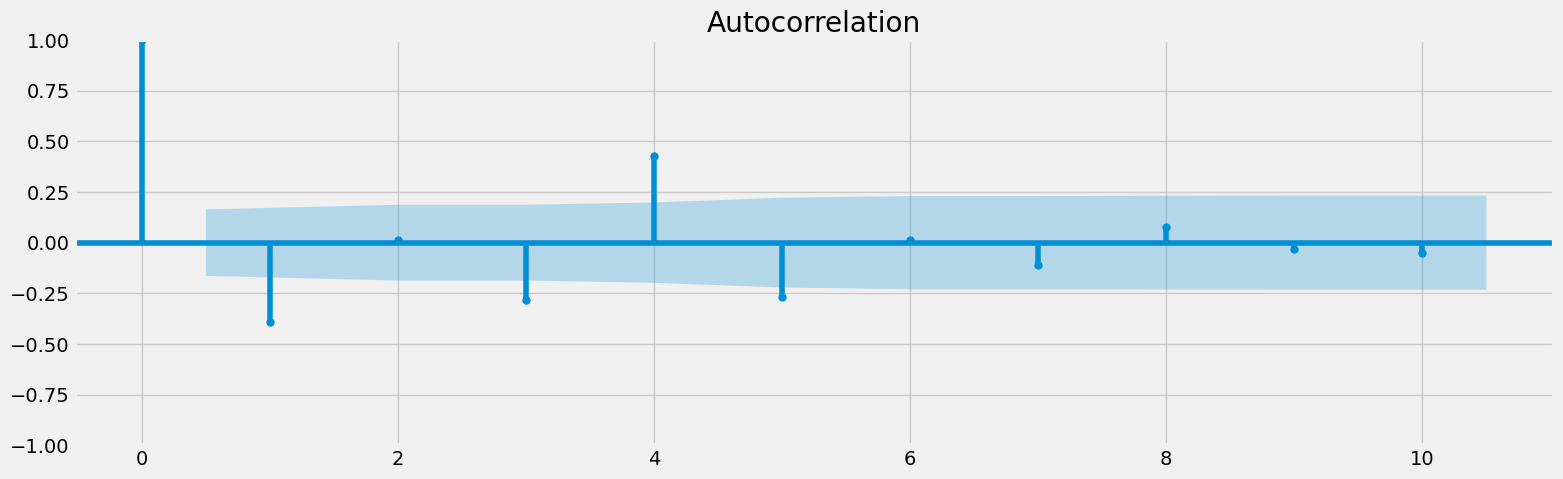

In [10]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax=plt.gca(), lags=10)
plt.show()

### Partial correlation function

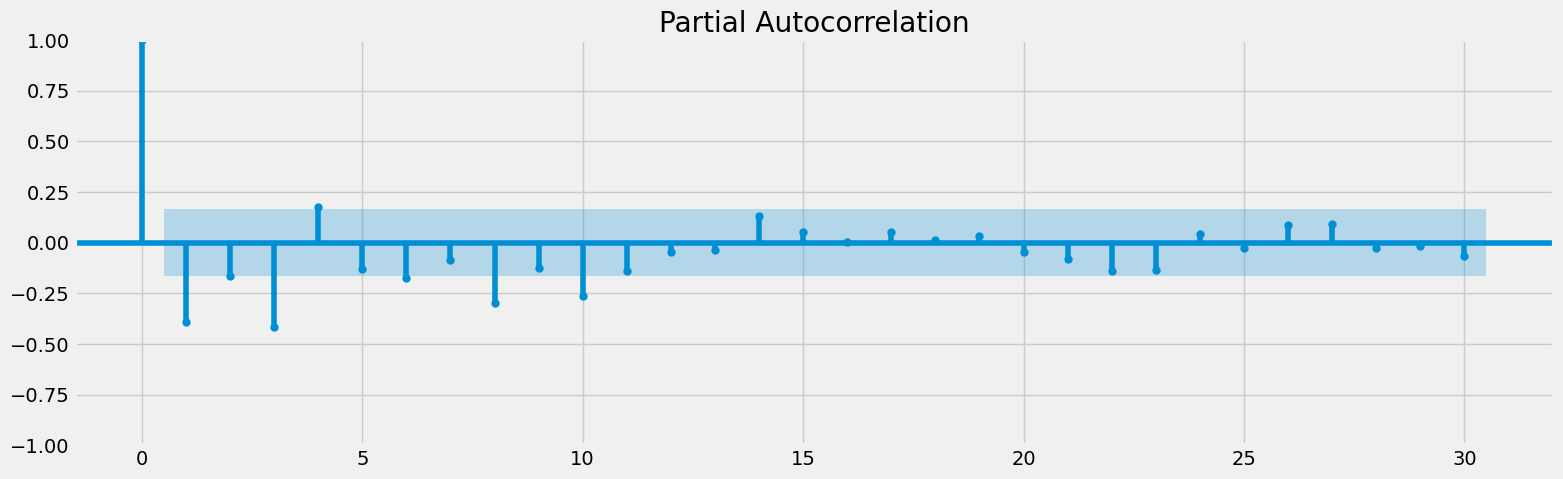

In [11]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax=plt.gca(), lags=30)
plt.show()

### Splitting the time series

In [14]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]

train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]

## Simple Auto Regressive Model

In [16]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

model_ar = ARIMA(train_data_boxcox_difference, order=(1,0,0))
model_fit = model_ar.fit()
print(model_fit.params)

const     0.012433
ar.L1    -0.402635
sigma2    0.059932
dtype: float64


C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
# recover original time series data
y_ar_new = data_boxcox_difference.copy()
y_ar_new['ar_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(), data_boxcox_difference.index.max())
y_ar_new['ar_forecast_boxcox'] = y_ar_new['ar_forecast_boxcox_difference'].cumsum()
y_ar_new['ar_forecast_boxcox'] = y_ar_new['ar_forecast_boxcox'].add(data_boxcox[0])
y_ar_new['ar_forecast'] = np.exp(y_ar_new['ar_forecast_boxcox'])

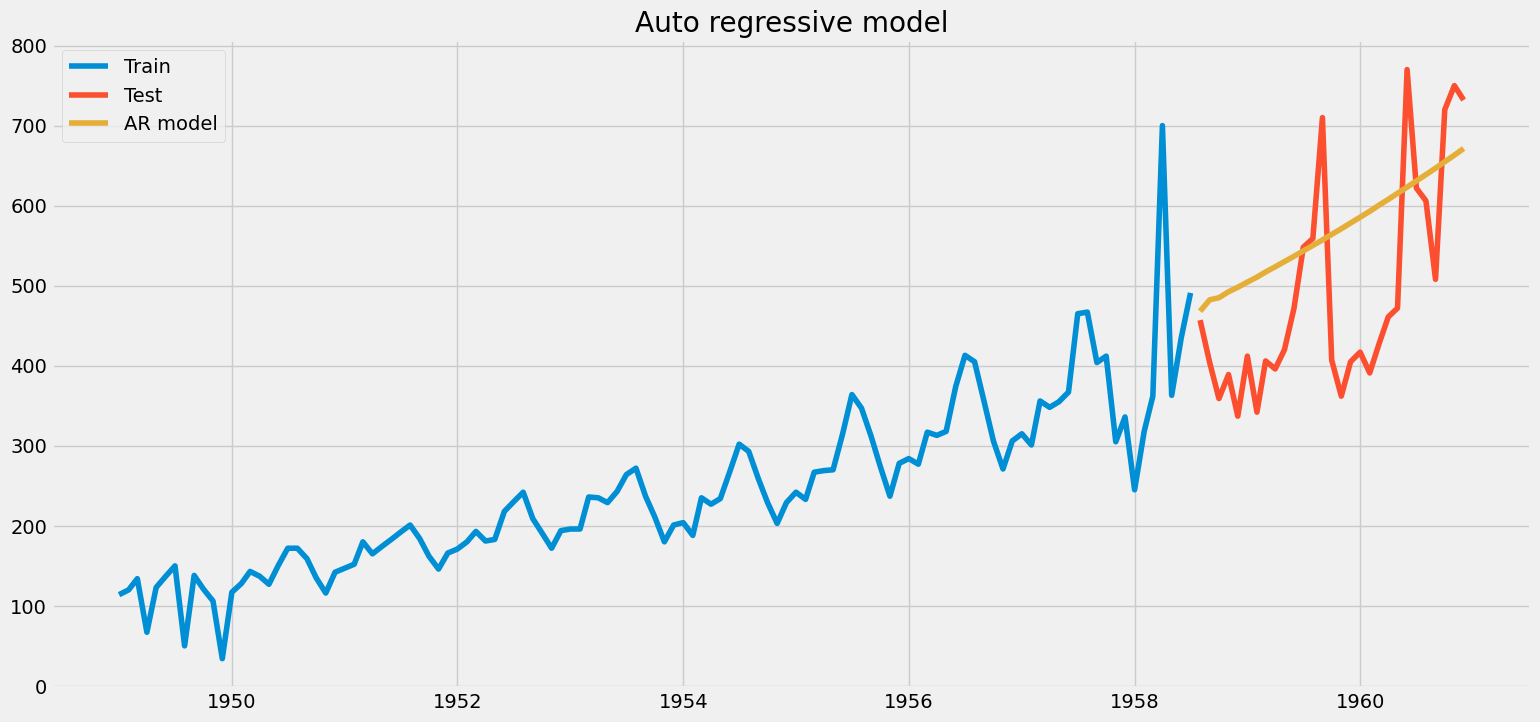

In [18]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_ar_new['ar_forecast'][test.index.min():], label = 'AR model')

plt.legend()
plt.title('Auto regressive model')
plt.show()

## Moving Average Model

In Moving Average Model, we consider the past forecasted errors to forecast the future values.

The moving average model has a parameter called “q” which is the size of the moving average window over which linear combinations of errors are calculated.

The mathematical equation is:-

y(t) = µ + φ(k)*ε(t-k)

µ is the mean of the series

ε(t-k) is the past forecasted value

φ(k) is the weight associated with error value


In [19]:
#from statsmodels.tsa.arima_model import ARIMA

model_ma = ARIMA(train_data_boxcox_difference, order=(0,0,7))
model_fit = model_ma.fit()
print(model_fit.params)

C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


const     0.012313
ma.L1    -0.538698
ma.L2    -0.215715
ma.L3    -0.160138
ma.L4     0.456323
ma.L5    -0.372360
ma.L6    -0.022698
ma.L7    -0.107899
sigma2    0.035812
dtype: float64


C:\Users\girij\anaconda3\envs\time-series\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# recover original time series
y_ma_new = data_boxcox_difference.copy()
y_ma_new['ma_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(), data_boxcox_difference.index.max())
y_ma_new['ma_forecast_boxcox'] = y_ma_new['ma_forecast_boxcox_difference'].cumsum()
y_ma_new['ma_forecast_boxcox'] = y_ma_new['ma_forecast_boxcox'].add(data_boxcox[0])
y_ma_new['ma_forecast'] = np.exp(y_ma_new['ma_forecast_boxcox'])

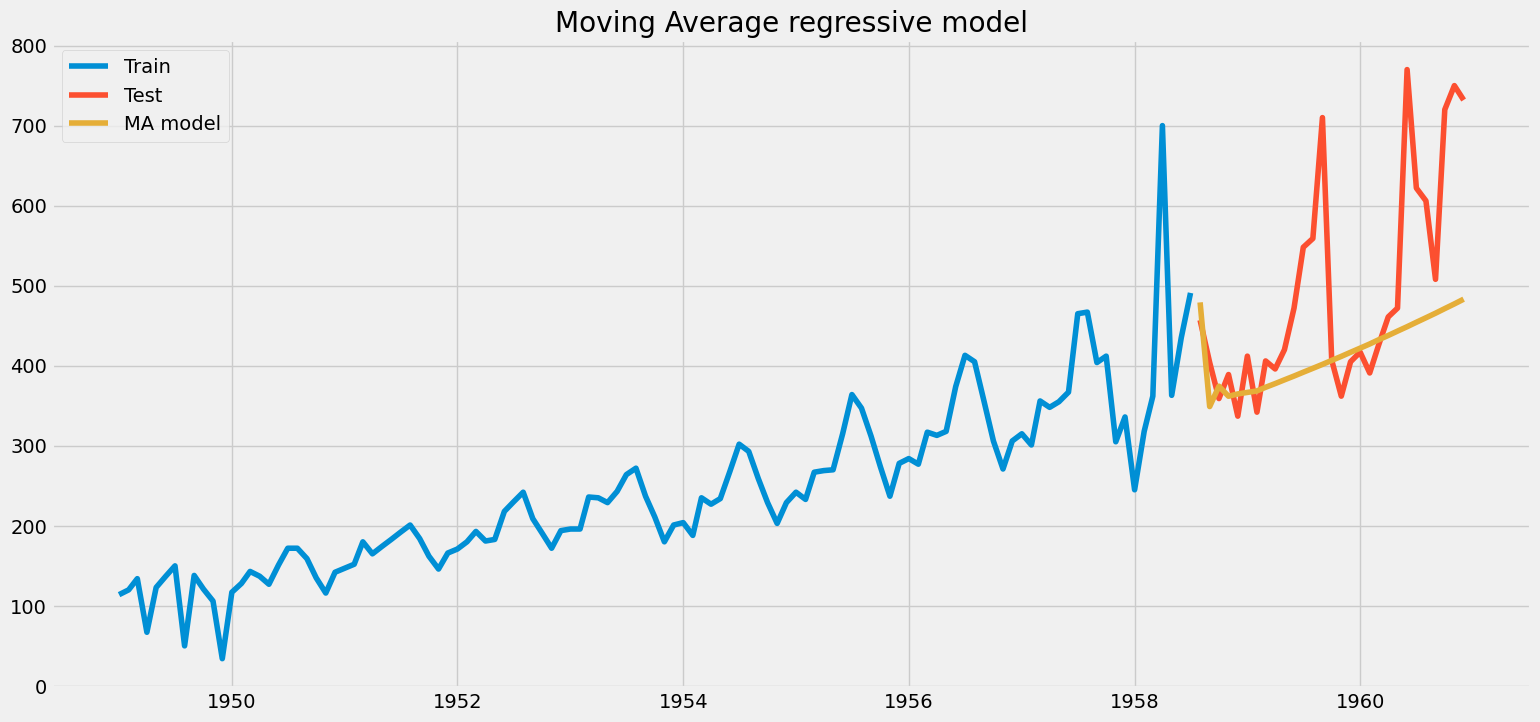

In [21]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_ma_new['ma_forecast'][test.index.min():], label = 'MA model')

plt.legend()
plt.title('Moving Average regressive model')
plt.show()